# Scaling analysis over number of curves outputted

This notebook evaluates how computational time and disk usage scale as the number of output curves increases in a Dynawo simulation.

What we want to show here is that storing all possible curves for a Dynawo simulation is impractical when dealing with a large network. When outputting a large number of curves, there's an overhead of writing all these curves to disk that will increase Dynawo's execution time (and, of course, disk usage). By storing only the essential data for later replay, we can avoid this computational time overhead and save up to 99% of disk space.

The analysis is conducted using the provided `t0` case, which represents a large-scale network with 7,784 buses. This case includes over 1,000 dynamic models, offering a sufficiently large set of output curves for a comprehensive scaling analysis. Note that this case requires the RTE private version of Dynawo for execution.

In [1]:
from dynawo_replay import ReplayableCase
from dynawo_replay.utils import list_available_vars

case = ReplayableCase(
    "./data/t0/fic_JOB.xml",
    dynawo="./interfaceDynamo_v1.7.0_powsybl/",
)
dyn_models = case.dyd.black_box_model
diff_libs = set(m.lib for m in dyn_models)
lib_vars = {lib: list_available_vars(lib) for lib in diff_libs}
all_curves = [(m.id, v.name) for m in dyn_models for v in lib_vars[m.lib]]
print(f"Total number of dynamic models {len(dyn_models)}.")
print(f"Total number of different models {len(diff_libs)}.")
print(f"Total number of curves that can be output {len(all_curves)}.")

Total number of dynamic models 1156.
Total number of different models 30.
Total number of curves that can be output 86410.


Below will be repeatedly running the Dynawo case scaling the number of curves to output and store the execution time it and the disk usage of the final output.

In [2]:
import random
from contexttimer import Timer
from dynawo_replay.schemas.curves_input import CurveInput

n_curves = [
    1,
    5,
    10,
    50,
    100,
    200,
    300,
    500,
    1000,
    2000,
    10000,
    20000,
    40000,
    len(all_curves),
]
exec_times = []
disk_usage = []
for n in n_curves:
    if n > len(all_curves):
        break
    curves = random.sample(all_curves, n)
    with Timer() as timer:
        with case.replica() as rep:
            rep.crv.curve = [CurveInput(m, v) for m, v in curves]
            rep.job.outputs.curves.export_mode = "CSV"
            rep.save()
            rep.run()
            du = rep.output_curves_path.stat().st_size / 1024 / 1024
    exec_times.append(timer.elapsed)
    disk_usage.append(du)
    print(f"{n} curves --> {timer.elapsed:.2f}s   {du:.2f}MB")

1 curves --> 41.56s   0.01MB
5 curves --> 44.22s   0.02MB
10 curves --> 42.02s   0.04MB
50 curves --> 43.54s   0.19MB
100 curves --> 40.65s   0.36MB
200 curves --> 47.75s   0.71MB
300 curves --> 41.00s   1.05MB
500 curves --> 40.73s   1.76MB
1000 curves --> 41.66s   3.51MB
2000 curves --> 42.45s   6.99MB
10000 curves --> 50.12s   35.03MB
20000 curves --> 59.69s   69.98MB
40000 curves --> 77.41s   140.08MB
86410 curves --> 122.70s   302.50MB


The execution time remains approximately constant at ~40 seconds when the number of curves to output is relatively small. However, starting from 1,000 curves, the overhead of writing all the curves to disk becomes significant, causing the computational time to grow linearly with the number of output curves.

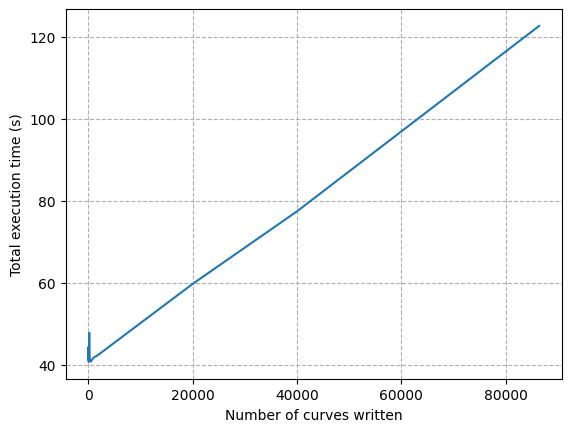

In [3]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.xlabel("Number of curves written")
plt.ylabel("Total execution time (s)")
plt.grid(True, which="both", linestyle="--")
plt.plot(n_curves, exec_times)

Of course, the disk usage also grows linearly with the number of curves to be output. 

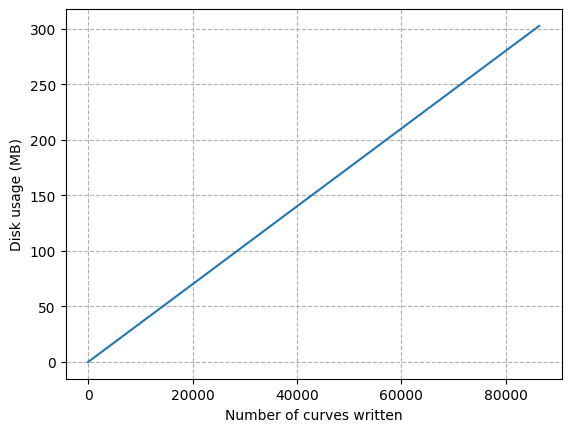

In [4]:
plt.xlabel("Number of curves written")
plt.ylabel("Disk usage (MB)")
plt.grid(True, which="both", linestyle="--")
plt.plot(n_curves, disk_usage)

So, for this case, if we want to save all possible curves we need 302MB in disk and 122s of computational time.

Instead, if we prepare the case with our `dynawo_replay` tool, the elapsed time remains at ~40s and the disk usage goes up to only 3.5MB. This is ~30% the time and ~1% the disk space and this is sufficient for later (quick) replay of all curves in this case. 

In [5]:
%%time
case.generate_replayable_base()

CPU times: user 4.35 s, sys: 477 ms, total: 4.83 s
Wall time: 45.6 s


In [6]:
!du -h {case.base_folder / 'replay'}

20K	/home/camposm/aia/dynawo-replay/notebooks/data/t0/replay/_template
3.4M	/home/camposm/aia/dynawo-replay/notebooks/data/t0/replay/_core
3.5M	/home/camposm/aia/dynawo-replay/notebooks/data/t0/replay
